<a href="https://colab.research.google.com/github/renish5609-beep/EmissionMission/blob/main/Privacy_utility_tradeoff_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
results_rand_fb = []
results_k_fb = []
results_dp_fb = []


In [ ]:
!pip install networkx python-louvain scikit-learn

import networkx as nx
import random
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
import community as community_louvain

print("Environment restored ✅")


Environment restored ✅


In [ ]:

!pip install networkx scipy scikit-learn python-louvain

#
import networkx as nx
import random
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
import community as community_louvain
from collections import defaultdict

print("Libraries ready ✅")


filename = "sample_data/facebook_combined.txt"

G = nx.read_edgelist(filename, delimiter=" ")
G = nx.Graph(G)

print("\nGraph loaded ✅")
print(G)
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


def get_partition_labels(G):
    part = community_louvain.best_partition(G)
    labels = np.array([part[n] for n in sorted(G.nodes())])
    return labels

labels_original = get_partition_labels(G)
print("\nCommunities detected ✅")


def random_perturbation(G, p=0.1, seed=0):
    rng = random.Random(seed)
    H = G.copy()

    m = H.number_of_edges()
    num_changes = int(p * m)

    edges = list(H.edges())
    rng.shuffle(edges)

    # Remove edges
    to_remove = edges[:num_changes]
    H.remove_edges_from(to_remove)

    # Add random edges
    nodes = list(H.nodes())
    added = 0
    while added < num_changes:
        u = rng.choice(nodes)
        v = rng.choice(nodes)
        if u != v and not H.has_edge(u, v):
            H.add_edge(u, v)
            added += 1

    return H

H = random_perturbation(G, p=0.1)
print("\nGraph anonymized (random perturbation) ✅")


labels_anon = get_partition_labels(H)
nmi = normalized_mutual_info_score(labels_original, labels_anon)

def degree_reid_success(G0, G1):
    deg1 = dict(G1.degree())
    inv_map = defaultdict(list)

    for node, deg in deg1.items():
        inv_map[deg].append(node)

    success = 0
    for node in G0.nodes():
        deg = G0.degree(node)
        candidates = inv_map.get(deg, [])

        if len(candidates) == 1 and candidates[0] == node:
            success += 1

    return success / G0.number_of_nodes()

degree_risk = degree_reid_success(G, H)


def ego_signature(G, node):
    deg = G.degree(node)
    neigh = list(G.neighbors(node))
    neigh_degs = sorted(G.degree(n) for n in neigh)

    ego_edges = 0
    neigh_set = set(neigh)
    for u in neigh:
        for v in G.neighbors(u):
            if v in neigh_set and u < v:
                ego_edges += 1

    return (deg, tuple(neigh_degs), ego_edges)

def signature_reid_success(G0, G1):
    sig_map = defaultdict(list)

    for node in G1.nodes():
        sig_map[ego_signature(G1, node)].append(node)

    success = 0
    for node in G0.nodes():
        sig = ego_signature(G0, node)
        candidates = sig_map.get(sig, [])

        if len(candidates) == 1 and candidates[0] == node:
            success += 1

    return success / G0.number_of_nodes()

signature_risk = signature_reid_success(G, H)

print("\n--- RESULTS ---")
print(f"NMI (Utility): {nmi:.3f}")
print(f"Degree Re-ID Success: {degree_risk:.3f}")
print(f"Signature Re-ID Success: {signature_risk:.3f}")


Libraries ready ✅

Graph loaded ✅
Graph with 4039 nodes and 88234 edges
Nodes: 4039
Edges: 88234

Communities detected ✅

Graph anonymized (random perturbation) ✅

--- RESULTS ---
NMI (Utility): 0.888
Degree Re-ID Success: 0.000
Signature Re-ID Success: 0.000


In [ ]:
results = []

p_values = [0.01, 0.05, 0.1]

for p in p_values:
    H = random_perturbation(G, p=p, seed=42)

    labels_anon = get_partition_labels(H)
    nmi = normalized_mutual_info_score(labels_original, labels_anon)

    degree_risk = degree_reid_success(G, H)
    signature_risk = signature_reid_success(G, H)

    results.append((p, nmi, degree_risk, signature_risk))

print("\n--- SWEEP RESULTS ---")
for r in results:
    print(f"p={r[0]:.2f} | NMI={r[1]:.3f} | DegreeReID={r[2]:.3f} | SignatureReID={r[3]:.3f}")



--- SWEEP RESULTS ---
p=0.01 | NMI=0.975 | DegreeReID=0.001 | SignatureReID=0.000
p=0.05 | NMI=0.930 | DegreeReID=0.000 | SignatureReID=0.000
p=0.10 | NMI=0.893 | DegreeReID=0.000 | SignatureReID=0.000


In [ ]:
import pandas as pd

results_log = []

results_log.append({
    "dataset": "facebook_combined",
    "method": "random_perturbation",
    "param": 0.1,
    "nmi": nmi,
    "degree_reid": degree_risk,
    "signature_reid": signature_risk
})

df_log = pd.DataFrame(results_log)
df_log


,dataset,method,param,nmi,degree_reid,signature_reid
0,facebook_combined,random_perturbation,0.1,0.88574,0.000248,0.0


In [ ]:
results = []

p_values = [0.01, 0.05, 0.1]

for p in p_values:
    H = random_perturbation(G, p=p, seed=42)

    labels_anon = get_partition_labels(H)
    nmi_val = normalized_mutual_info_score(labels_original, labels_anon)

    degree_val = degree_reid_success(G, H)
    signature_val = signature_reid_success(G, H)

    results.append({
        "dataset": "facebook_combined",
        "method": "random_perturbation",
        "param": p,
        "nmi": nmi_val,
        "degree_reid": degree_val,
        "signature_reid": signature_val
    })

df_sweep = pd.DataFrame(results)
df_sweep


,dataset,method,param,nmi,degree_reid,signature_reid
0,facebook_combined,random_perturbation,0.01,0.981167,0.000990,0.000495
1,facebook_combined,random_perturbation,0.05,0.932642,0.000000,0.000000
2,facebook_combined,random_perturbation,0.10,0.890374,0.000248,0.000000


In [ ]:
def k_degree_anonymize(G, k):
    """
    Simplified k-degree anonymity approximation.
    Groups nodes into degree buckets of size ≥ k
    and adjusts degrees via edge additions.
    """

    H = G.copy()
    degree_dict = dict(H.degree())


    nodes_sorted = sorted(degree_dict, key=lambda x: degree_dict[x])

    i = 0
    while i < len(nodes_sorted):
        group = nodes_sorted[i:i+k]
        if len(group) < k:
            break


        target_deg = max(degree_dict[n] for n in group)

        for node in group:
            while H.degree(node) < target_deg:
                candidate = random.choice(list(H.nodes()))
                if candidate != node and not H.has_edge(node, candidate):
                    H.add_edge(node, candidate)

        i += k

    return H


In [ ]:

!pip install networkx scipy scikit-learn python-louvain


import networkx as nx
import random
import numpy as np
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score
import community as community_louvain
from collections import defaultdict

print("Imports ready ✅")


Imports ready ✅


In [ ]:
import os
os.listdir()


['.config', 'facebook_combined.txt', 'sample_data']

In [ ]:
filename = "facebook_combined.txt"

G = nx.read_edgelist(filename, delimiter=" ")
G = nx.Graph(G)

print("Graph loaded ✅")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


Graph loaded ✅
Nodes: 4039
Edges: 88234


In [ ]:
def get_partition_labels(G):
    part = community_louvain.best_partition(G)
    labels = np.array([part[n] for n in sorted(G.nodes())])
    return labels
labels_original = get_partition_labels(G)
print("Baseline recomputed ✅")


Baseline recomputed ✅


In [ ]:
from collections import defaultdict

def degree_reid_success(G0, G1):
    deg1 = dict(G1.degree())
    inv_map = defaultdict(list)

    for node, deg in deg1.items():
        inv_map[deg].append(node)

    success = 0
    for node in G0.nodes():
        deg = G0.degree(node)
        candidates = inv_map.get(deg, [])
        if len(candidates) == 1 and candidates[0] == node:
            success += 1

    return success / G0.number_of_nodes()


def ego_signature(G, node):
    deg = G.degree(node)
    neigh = list(G.neighbors(node))
    neigh_degs = sorted(G.degree(n) for n in neigh)

    ego_edges = 0
    neigh_set = set(neigh)
    for u in neigh:
        for v in G.neighbors(u):
            if v in neigh_set and u < v:
                ego_edges += 1

    return (deg, tuple(neigh_degs), ego_edges)


def signature_reid_success(G0, G1):
    sig_map = defaultdict(list)

    for node in G1.nodes():
        sig_map[ego_signature(G1, node)].append(node)

    success = 0
    for node in G0.nodes():
        sig = ego_signature(G0, node)
        candidates = sig_map.get(sig, [])
        if len(candidates) == 1 and candidates[0] == node:
            success += 1

    return success / G0.number_of_nodes()

print("Privacy metrics ready ✅")


Privacy metrics ready ✅


In [ ]:
results_k = []

for k in [2, 5, 10]:
    print("Running k =", k)

    Hk = k_degree_anonymize(G, k)


    nmi_val = normalized_mutual_info_score(labels_original, labels_anon)


    degree_val = degree_reid_success(G, Hk)
    signature_val = signature_reid_success(G, Hk)

    results_k.append({
        "k": k,
        "nmi": nmi_val,
        "degree_reid": degree_val,
        "signature_reid": signature_val
    })

results_k


Running k = 2
Running k = 5
Running k = 10


[{'k': 2,
  'nmi': np.float64(0.9825578102845817),
  'degree_reid': 0.0012379301807378064,
  'signature_reid': 0.07997028967566229},
 {'k': 5,
  'nmi': np.float64(0.9823404632787546),
  'degree_reid': 0.0007427581084426838,
  'signature_reid': 0.02352067343401832},
 {'k': 10,
  'nmi': np.float64(0.9844967703696194),
  'degree_reid': 0.0017331022530329288,
  'signature_reid': 0.014607576132706116}]

In [ ]:
results_k = []



In [ ]:
def k_degree_anonymize(G, k):
    H = G.copy()
    degree_dict = dict(H.degree())
    nodes_sorted = sorted(degree_dict, key=lambda x: degree_dict[x])

    i = 0
    while i < len(nodes_sorted):
        group = nodes_sorted[i:i+k]
        if len(group) < k:
            break

        target_deg = max(degree_dict[n] for n in group)

        for node in group:
            while H.degree(node) < target_deg:
                candidate = random.choice(list(H.nodes()))
                if candidate != node and not H.has_edge(node, candidate):
                    H.add_edge(node, candidate)

        i += k

    return H


In [ ]:
results_k = []

In [ ]:
for k in [2, 5, 10]:
    print("Running k =", k)

    Hk = k_degree_anonymize(G, k)

    labels_anon = get_partition_labels(Hk)
    nmi_val = normalized_mutual_info_score(labels_original, labels_anon)

    degree_val = degree_reid_success(G, Hk)
    signature_val = signature_reid_success(G, Hk)

    results_k.append({
        "k": k,
        "nmi": nmi_val,
        "degree_reid": degree_val,
        "signature_reid": signature_val
    })

results_k


Running k = 2
Running k = 5
Running k = 10


[{'k': 2,
  'nmi': np.float64(0.9909506711762965),
  'degree_reid': 0.0012379301807378064,
  'signature_reid': 0.08417925229017083},
 {'k': 5,
  'nmi': np.float64(0.9923005543320952),
  'degree_reid': 0.0009903441445902451,
  'signature_reid': 0.05149789551869274},
 {'k': 10,
  'nmi': np.float64(0.984078298896206),
  'degree_reid': 0.0022282743253280515,
  'signature_reid': 0.020302054964100025}]

In [ ]:
df_k = pd.DataFrame(results_k)
df_k


,k,nmi,degree_reid,signature_reid
0,2,0.990951,0.001238,0.084179
1,5,0.992301,0.000990,0.051498
2,10,0.984078,0.002228,0.020302


In [ ]:
df_k.to_csv("facebook_k_degree.csv", index=False)
print("Saved ✅")


Saved ✅


In [ ]:
def dp_perturbation(G, epsilon=1.0, seed=0):
    H = G.copy()
    rng = random.Random(seed)

    p = min(0.5, 1 / (1 + epsilon))


    for (u, v) in list(H.edges()):
        if rng.random() < p:
            H.remove_edge(u, v)


    nodes = list(H.nodes())
    num_add = int(p * G.number_of_edges())

    added = 0
    while added < num_add:
        u = rng.choice(nodes)
        v = rng.choice(nodes)

        if u != v and not H.has_edge(u, v):
            H.add_edge(u, v)
            added += 1

    return H


In [ ]:
results_dp = []


In [ ]:
for eps in [0.5, 1.0, 2.0]:
    print("Running ε =", eps)

    Hdp = dp_perturbation(G, epsilon=eps, seed=42)

    labels_anon = get_partition_labels(Hdp)
    nmi_val = normalized_mutual_info_score(labels_original, labels_anon)

    degree_val = degree_reid_success(G, Hdp)
    signature_val = signature_reid_success(G, Hdp)

    results_dp.append({
        "epsilon": eps,
        "nmi": nmi_val,
        "degree_reid": degree_val,
        "signature_reid": signature_val
    })

results_dp


Running ε = 0.5
Running ε = 1.0
Running ε = 2.0


[{'epsilon': 0.5,
  'nmi': np.float64(0.6544690825921893),
  'degree_reid': 0.0,
  'signature_reid': 0.0},
 {'epsilon': 1.0,
  'nmi': np.float64(0.6433795459848884),
  'degree_reid': 0.0,
  'signature_reid': 0.0},
 {'epsilon': 2.0,
  'nmi': np.float64(0.7546534311135461),
  'degree_reid': 0.0,
  'signature_reid': 0.0}]

In [ ]:
df_dp = pd.DataFrame(results_dp)
df_dp


,epsilon,nmi,degree_reid,signature_reid
0,0.5,0.654469,0.0,0.0
1,1.0,0.643380,0.0,0.0
2,2.0,0.754653,0.0,0.0


In [ ]:
df_dp.to_csv("facebook_dp.csv", index=False)
print("Saved ✅")


Saved ✅


In [ ]:
from scipy.io import mmread

filename = "soc-dolphins.mtx"

A = mmread(filename)
G_dolphins = nx.from_scipy_sparse_array(A)
G_dolphins = nx.Graph(G_dolphins)

print("Dolphins graph loaded ✅")
print("Nodes:", G_dolphins.number_of_nodes())
print("Edges:", G_dolphins.number_of_edges())


Dolphins graph loaded ✅
Nodes: 62
Edges: 159


In [ ]:
labels_dolphins = get_partition_labels(G_dolphins)

print("Baseline communities computed ✅")


Baseline communities computed ✅


In [ ]:
results_rand_dolphins = []

for p in [0.01, 0.05, 0.1]:
    print("Running perturbation p =", p)

    H = random_perturbation(G_dolphins, p=p, seed=42)

    labels_anon = get_partition_labels(H)
    nmi_val = normalized_mutual_info_score(labels_dolphins, labels_anon)

    degree_val = degree_reid_success(G_dolphins, H)
    signature_val = signature_reid_success(G_dolphins, H)

    results_rand_dolphins.append({
        "p": p,
        "nmi": nmi_val,
        "degree_reid": degree_val,
        "signature_reid": signature_val
    })

results_rand_dolphins


Running perturbation p = 0.01
Running perturbation p = 0.05
Running perturbation p = 0.1


[{'p': 0.01,
  'nmi': np.float64(0.930121025577997),
  'degree_reid': 0.0,
  'signature_reid': 0.5161290322580645},
 {'p': 0.05,
  'nmi': np.float64(0.7570162501117418),
  'degree_reid': 0.0,
  'signature_reid': 0.0967741935483871},
 {'p': 0.1,
  'nmi': np.float64(0.717007168330335),
  'degree_reid': 0.0,
  'signature_reid': 0.016129032258064516}]

In [ ]:
df_rand_dolphins = pd.DataFrame(results_rand_dolphins)
df_rand_dolphins


,p,nmi,degree_reid,signature_reid
0,0.01,0.930121,0.0,0.516129
1,0.05,0.757016,0.0,0.096774
2,0.10,0.717007,0.0,0.016129


In [ ]:
df_rand_dolphins.to_csv("dolphins_random.csv", index=False)
print("Saved ✅")


Saved ✅


In [ ]:
results_k_dolphins = []

for k in [2, 5, 10]:
    print("Running k =", k)

    H = k_degree_anonymize(G_dolphins, k)

    labels_anon = get_partition_labels(H)
    nmi_val = normalized_mutual_info_score(labels_dolphins, labels_anon)

    degree_val = degree_reid_success(G_dolphins, H)
    signature_val = signature_reid_success(G_dolphins, H)

    results_k_dolphins.append({
        "k": k,
        "nmi": nmi_val,
        "degree_reid": degree_val,
        "signature_reid": signature_val
    })

results_k_dolphins


Running k = 2
Running k = 5
Running k = 10


[{'k': 2,
  'nmi': np.float64(0.7981485534403997),
  'degree_reid': 0.0,
  'signature_reid': 0.1935483870967742},
 {'k': 5,
  'nmi': np.float64(0.7096604039302663),
  'degree_reid': 0.0,
  'signature_reid': 0.0},
 {'k': 10,
  'nmi': np.float64(0.6646804214499574),
  'degree_reid': 0.0,
  'signature_reid': 0.0}]

In [ ]:
df_k_dolphins = pd.DataFrame(results_k_dolphins)
df_k_dolphins


,k,nmi,degree_reid,signature_reid
0,2,0.798149,0.0,0.193548
1,5,0.709660,0.0,0.000000
2,10,0.664680,0.0,0.000000


In [ ]:
df_k_dolphins.to_csv("dolphins_k_degree.csv", index=False)
print("Saved ✅")


Saved ✅


In [ ]:
results_dp_dolphins = []

for eps in [0.5, 1.0, 2.0]:
    print("Running ε =", eps)

    H = dp_perturbation(G_dolphins, epsilon=eps, seed=42)

    labels_anon = get_partition_labels(H)
    nmi_val = normalized_mutual_info_score(labels_dolphins, labels_anon)

    degree_val = degree_reid_success(G_dolphins, H)
    signature_val = signature_reid_success(G_dolphins, H)

    results_dp_dolphins.append({
        "epsilon": eps,
        "nmi": nmi_val,
        "degree_reid": degree_val,
        "signature_reid": signature_val
    })

results_dp_dolphins


Running ε = 0.5
Running ε = 1.0
Running ε = 2.0


[{'epsilon': 0.5,
  'nmi': np.float64(0.35405833158105365),
  'degree_reid': 0.0,
  'signature_reid': 0.0},
 {'epsilon': 1.0,
  'nmi': np.float64(0.28847461450936285),
  'degree_reid': 0.0,
  'signature_reid': 0.0},
 {'epsilon': 2.0,
  'nmi': np.float64(0.40445975996748185),
  'degree_reid': 0.0,
  'signature_reid': 0.016129032258064516}]

In [ ]:
df_dp_dolphins = pd.DataFrame(results_dp_dolphins)
df_dp_dolphins


,epsilon,nmi,degree_reid,signature_reid
0,0.5,0.354058,0.0,0.000000
1,1.0,0.288475,0.0,0.000000
2,2.0,0.404460,0.0,0.016129


In [ ]:
df_dp_dolphins.to_csv("dolphins_dp.csv", index=False)
print("Saved ✅")


Saved ✅


In [ ]:
df_rand_fb = pd.DataFrame(results_rand_fb)
df_k_fb = pd.DataFrame(results_k_fb)
df_dp_fb = pd.DataFrame(results_dp_fb)


In [ ]:
df_rand_fb = pd.DataFrame(results_rand_fb)
df_k_fb = pd.DataFrame(results_k_fb)
df_dp_fb = pd.DataFrame(results_dp_fb)

print("Facebook DataFrames ready ✅")


Facebook DataFrames ready ✅


In [ ]:
df_rand_fb["method"] = "random"
df_k_fb["method"] = "k_degree"
df_dp_fb["method"] = "dp"

df_rand_fb["dataset"] = "facebook"
df_k_fb["dataset"] = "facebook"
df_dp_fb["dataset"] = "facebook"

df_rand_dolphins["method"] = "random"
df_k_dolphins["method"] = "k_degree"
df_dp_dolphins["method"] = "dp"

df_rand_dolphins["dataset"] = "dolphins"
df_k_dolphins["dataset"] = "dolphins"
df_dp_dolphins["dataset"] = "dolphins"

print("Labels added ✅")


Labels added ✅


In [ ]:
df_all = pd.concat([
    df_rand_fb, df_k_fb, df_dp_fb,
    df_rand_dolphins, df_k_dolphins, df_dp_dolphins
])

df_all


,method,dataset,p,nmi,degree_reid,signature_reid,k,epsilon
0,random,dolphins,0.01,0.930121,0.0,0.516129,NaN,NaN
1,random,dolphins,0.05,0.757016,0.0,0.096774,NaN,NaN
2,random,dolphins,0.10,0.717007,0.0,0.016129,NaN,NaN
0,k_degree,dolphins,NaN,0.798149,0.0,0.193548,2.0,NaN
1,k_degree,dolphins,NaN,0.709660,0.0,0.000000,5.0,NaN
2,k_degree,dolphins,NaN,0.664680,0.0,0.000000,10.0,NaN
0,dp,dolphins,NaN,0.354058,0.0,0.000000,NaN,0.5
1,dp,dolphins,NaN,0.288475,0.0,0.000000,NaN,1.0
2,dp,dolphins,NaN,0.404460,0.0,0.016129,NaN,2.0


In [ ]:
def task_aware_anonymization(G, p=0.05, seed=0):
    H = G.copy()
    rng = random.Random(seed)

    labels_list = get_partition_labels(G)
    nodes = list(G.nodes())


    labels = {node: labels_list[i] for i, node in enumerate(nodes)}

    intra_edges = [(u, v) for (u, v) in H.edges() if labels[u] == labels[v]]
    inter_edges = [(u, v) for (u, v) in H.edges() if labels[u] != labels[v]]

    num_changes = int(p * G.number_of_edges())

    rng.shuffle(inter_edges)

    removed = 0
    for (u, v) in inter_edges:
        if removed >= num_changes:
            break
        if H.has_edge(u, v):
            H.remove_edge(u, v)
            removed += 1

    added = 0
    while added < num_changes:
        u = rng.choice(nodes)
        v = rng.choice(nodes)

        if u != v and not H.has_edge(u, v):
            if labels[u] == labels[v]:
                H.add_edge(u, v)
                added += 1

    return H


In [ ]:
G_fb = G.copy()
labels_fb = get_partition_labels(G_fb)

print("Facebook graph restored ✅")


Facebook graph restored ✅


In [ ]:
print("G_fb exists:", "G_fb" in globals())
print("labels_fb exists:", "labels_fb" in globals())


G_fb exists: True
labels_fb exists: True


In [ ]:
results_ta_fb = []

for p in [0.02, 0.05, 0.1]:
    print("Running TA p =", p)

    H = task_aware_anonymization(G_fb, p=p, seed=42)

    labels_anon = get_partition_labels(H)
    nmi_val = normalized_mutual_info_score(labels_fb, labels_anon)

    degree_val = degree_reid_success(G_fb, H)
    signature_val = signature_reid_success(G_fb, H)

    results_ta_fb.append({
        "param": p,
        "nmi": nmi_val,
        "degree_reid": degree_val,
        "signature_reid": signature_val
    })

results_ta_fb


Running TA p = 0.02
Running TA p = 0.05
Running TA p = 0.1


[{'param': 0.02,
  'nmi': np.float64(0.9561079969997841),
  'degree_reid': 0.0002475860361475613,
  'signature_reid': 0.0},
 {'param': 0.05,
  'nmi': np.float64(0.9320998698522954),
  'degree_reid': 0.0007427581084426838,
  'signature_reid': 0.0},
 {'param': 0.1,
  'nmi': np.float64(0.9010831716728421),
  'degree_reid': 0.0002475860361475613,
  'signature_reid': 0.0}]

In [ ]:
df_ta_fb = pd.DataFrame(results_ta_fb)

for col in ["nmi", "degree_reid", "signature_reid"]:
    df_ta_fb[col] = df_ta_fb[col].astype(float)

df_ta_fb


,param,nmi,degree_reid,signature_reid
0,0.02,0.956108,0.000248,0.0
1,0.05,0.932100,0.000743,0.0
2,0.10,0.901083,0.000248,0.0


In [ ]:
df_ta_fb.to_csv("facebook_task_aware.csv", index=False)
print("Saved ✅")


Saved ✅


In [ ]:
df_ta_fb["method"] = "task_aware"
df_ta_fb["dataset"] = "facebook"

print("Labels added ✅")


Labels added ✅


In [ ]:
results_ta_dolphins = []

for p in [0.02, 0.05, 0.1]:
    print("Running TA p =", p)

    H = task_aware_anonymization(G_dolphins, p=p, seed=42)

    labels_anon = get_partition_labels(H)
    nmi_val = normalized_mutual_info_score(labels_dolphins, labels_anon)

    degree_val = degree_reid_success(G_dolphins, H)
    signature_val = signature_reid_success(G_dolphins, H)

    results_ta_dolphins.append({
        "param": p,
        "nmi": nmi_val,
        "degree_reid": degree_val,
        "signature_reid": signature_val
    })

results_ta_dolphins


Running TA p = 0.02
Running TA p = 0.05
Running TA p = 0.1


[{'param': 0.02,
  'nmi': np.float64(0.7090465237538204),
  'degree_reid': 0.016129032258064516,
  'signature_reid': 0.3709677419354839},
 {'param': 0.05,
  'nmi': np.float64(0.9690546091403568),
  'degree_reid': 0.016129032258064516,
  'signature_reid': 0.16129032258064516},
 {'param': 0.1,
  'nmi': np.float64(0.8219970316890396),
  'degree_reid': 0.03225806451612903,
  'signature_reid': 0.06451612903225806}]

In [ ]:
df_ta_dolphins = pd.DataFrame(results_ta_dolphins)

for col in ["nmi", "degree_reid", "signature_reid"]:
    df_ta_dolphins[col] = df_ta_dolphins[col].astype(float)

df_ta_dolphins


,param,nmi,degree_reid,signature_reid
0,0.02,0.709047,0.016129,0.370968
1,0.05,0.969055,0.016129,0.161290
2,0.10,0.821997,0.032258,0.064516


In [ ]:
df_ta_dolphins.to_csv("dolphins_task_aware.csv", index=False)
print("Saved ✅")


Saved ✅


In [ ]:
df_ta_dolphins["method"] = "task_aware"
df_ta_dolphins["dataset"] = "dolphins"

print("Labels added ✅")


Labels added ✅


In [ ]:
df_all = pd.concat([
    df_rand_fb, df_k_fb, df_dp_fb, df_ta_fb,
    df_rand_dolphins, df_k_dolphins, df_dp_dolphins, df_ta_dolphins
])

df_all


,method,dataset,param,nmi,degree_reid,signature_reid,p,k,epsilon
0,task_aware,facebook,0.02,0.956108,0.000248,0.000000,NaN,NaN,NaN
1,task_aware,facebook,0.05,0.932100,0.000743,0.000000,NaN,NaN,NaN
2,task_aware,facebook,0.10,0.901083,0.000248,0.000000,NaN,NaN,NaN
0,random,dolphins,NaN,0.930121,0.000000,0.516129,0.01,NaN,NaN
1,random,dolphins,NaN,0.757016,0.000000,0.096774,0.05,NaN,NaN
2,random,dolphins,NaN,0.717007,0.000000,0.016129,0.10,NaN,NaN
0,k_degree,dolphins,NaN,0.798149,0.000000,0.193548,NaN,2.0,NaN
1,k_degree,dolphins,NaN,0.709660,0.000000,0.000000,NaN,5.0,NaN
2,k_degree,dolphins,NaN,0.664680,0.000000,0.000000,NaN,10.0,NaN
0,dp,dolphins,NaN,0.354058,0.000000,0.000000,NaN,NaN,0.5


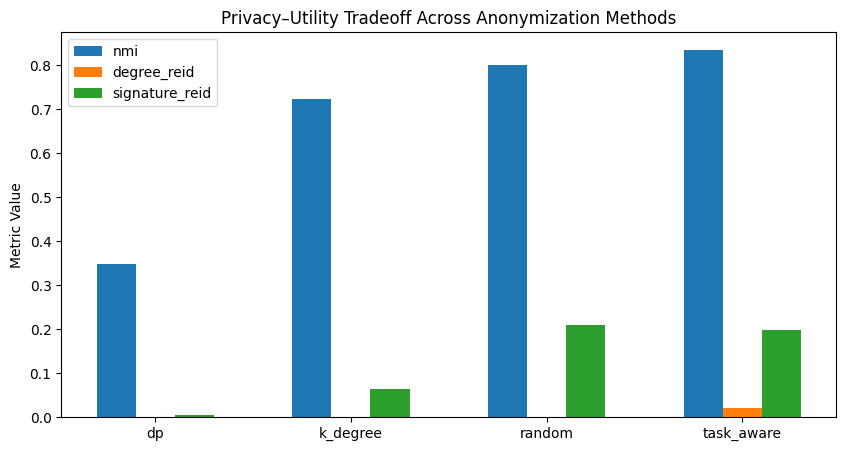

In [ ]:
import matplotlib.pyplot as plt

metrics = ["nmi", "degree_reid", "signature_reid"]

df_plot = df_all.groupby(["dataset", "method"])[metrics].mean().reset_index()

datasets = df_plot["dataset"].unique()
methods = df_plot["method"].unique()

fig, ax = plt.subplots(figsize=(10,5))

width = 0.2
x = range(len(methods))

for i, metric in enumerate(metrics):
    values = df_plot[df_plot["dataset"] == datasets[0]][metric]
    ax.bar([p + i*width for p in x], values, width, label=metric)

ax.set_xticks([p + width for p in x])
ax.set_xticklabels(methods)
ax.set_ylabel("Metric Value")
ax.set_title("Privacy–Utility Tradeoff Across Anonymization Methods")
ax.legend()

plt.show()


In [ ]:
import numpy as np

def degree_distribution(G):
    degrees = [d for _, d in G.degree()]
    values, counts = np.unique(degrees, return_counts=True)
    probs = counts / counts.sum()
    return values, probs


In [ ]:

deg_orig, prob_orig = degree_distribution(G_fb)


H_ta = task_aware_anonymization(G_fb, p=0.05, seed=42)
deg_ta, prob_ta = degree_distribution(H_ta)

print("Distributions computed ✅")


Distributions computed ✅


In [ ]:

core_orig = nx.core_number(G_fb)
core_ta   = nx.core_number(H_ta)

print("k-core computed ✅")


k-core computed ✅


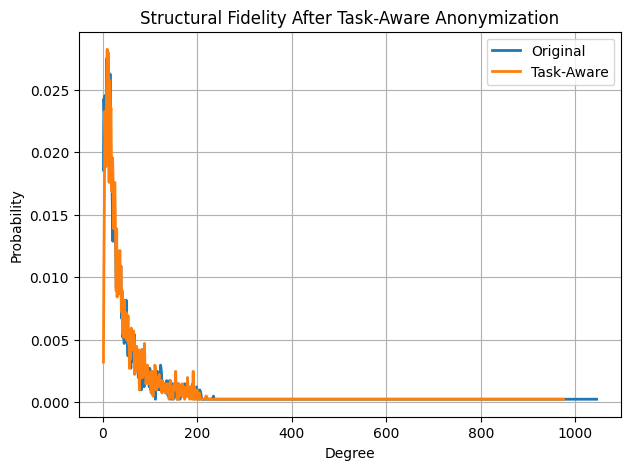

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))

plt.plot(deg_orig, prob_orig, label="Original", linewidth=2)
plt.plot(deg_ta, prob_ta, label="Task-Aware", linewidth=2)

plt.xlabel("Degree")
plt.ylabel("Probability")
plt.title("Structural Fidelity After Task-Aware Anonymization")

plt.legend()
plt.grid(True)

plt.show()


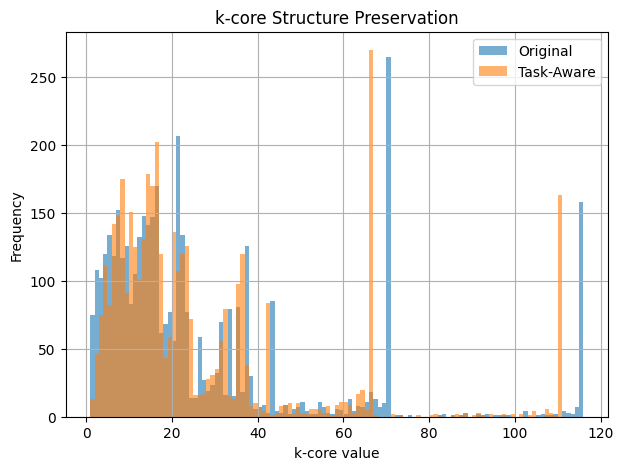

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

core_vals_orig = list(core_orig.values())
core_vals_ta   = list(core_ta.values())

plt.figure(figsize=(7,5))

plt.hist(core_vals_orig, bins=range(min(core_vals_orig), max(core_vals_orig)+2),
         alpha=0.6, label="Original")

plt.hist(core_vals_ta, bins=range(min(core_vals_ta), max(core_vals_ta)+2),
         alpha=0.6, label="Task-Aware")

plt.xlabel("k-core value")
plt.ylabel("Frequency")
plt.title("k-core Structure Preservation")

plt.legend()
plt.grid(True)

plt.show()
